# Convergence of Syntactic Complexity in Conversation

Research based on 'Convergence of Syntactic Complexity in Conversation' by Yang Xu and David Reitter, 2016.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import nltk
from collections import defaultdict
from scipy.stats import binned_statistic

In [2]:
from swda_time import CorpusReader
corpus = CorpusReader('swda_time', 'swda_time/swda-metadata-ext.csv')

In [3]:
ttt = nltk.tokenize.TextTilingTokenizer()

## UtteranceWrapper class

Wrapper for collected utterance data

In [4]:
class UtteranceWrapper:
    def __init__(self, speaker, text, length, depth, width):
        self.speaker = speaker
        self.text = text
        self.length = length
        self.depth = depth
        self.width = width
        self.ntd = None
        self.ntw = None
        
    def set_ntd(self, ntd_const):
        self.ntd = self.depth / float(ntd_const)
        
    def set_ntw(self, ntw_const):
        self.ntw = self.width / float(ntw_const)
        
    def get_all_measures(self):
        return [self.length, self.depth, self.width, self.ntd, self.ntw]

## Collect speaker data

In [5]:
COLLECTOR_VERBOSE = False

def collect_transcript_data():
    transcripts_list = []
    for transcript in corpus.iter_transcripts(display_progress=True):
        conversation_list = []
        for utterance in transcript.utterances:

    #         sub_utterance = utterance.subutterance_index
    #         print(sub_utterance)

            speaker = utterance.caller
            if COLLECTOR_VERBOSE: print(speaker)
            text = utterance.pos_words()
            if COLLECTOR_VERBOSE: print(text)
            tree = utterance.trees[0] 
            
            # TODO: Currently only considering the first tree # # # # # # # # #
            # TODO: Handle cases where no tree is found # # # # # # # # # # # # 
            
            if COLLECTOR_VERBOSE: tree.pretty_print()
            subtrees = tree.subtrees()

            # Collect syntactic complexity metrics
            # Sentence length
            sentence_length = len(text)
            if COLLECTOR_VERBOSE: print(sentence_length)

            # Tree depth
            tree_depth = tree.height()
            if COLLECTOR_VERBOSE: print(tree_depth)

            node_count = 0
            branching_sum = 0        
            # Branching factor        
            for t in subtrees: 
                if COLLECTOR_VERBOSE: print(t)
                num_children = len(t.leaves())
                if COLLECTOR_VERBOSE: print(num_children)
                node_count += 1
                branching_sum += num_children

            tree_width = branching_sum / float(node_count)
            if COLLECTOR_VERBOSE: print(tree_width)

    #         pos = utterance.pos_lemmas()
    #         print(pos)

            wrapper = UtteranceWrapper(speaker, text, sentence_length, tree_depth, tree_width)
            conversation_list.append(wrapper)
        transcripts_list.append(conversation_list)
        
        break
        # TODO: Remove # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    return transcripts_list

In [6]:
transcripts_list = collect_transcript_data()

transcript 1

## Calculate normalized measures from collected data

In [7]:
def collect_normalized_data(transcripts_list):
    length_sum = 0
    depth_sum = 0
    width_sum = 0

    depth_normalizer_dict = defaultdict(lambda: list())
    width_normalizer_dict = defaultdict(lambda: list())
    
    for wrapper_list in transcripts_list:
        for i, wrapper in enumerate(wrapper_list):
            length = wrapper.length
            depth = wrapper.depth
            width = wrapper.width

        #     print("Utterance {}: Length {} - Depth {} - Width {}".format(i, length, depth, width))

            length_sum += length
            depth_sum += depth
            width_sum += width

            depth_normalizer_dict[length].append(depth)
            width_normalizer_dict[length].append(width)

        print("Average: Length {} - Depth {} - Width {}".format(
            length_sum / float(len(wrapper_list)), 
            depth_sum / float(len(wrapper_list)),
            width_sum / float(len(wrapper_list))))

        depth_normalizer_const = dict()
        width_normalizer_const = dict()

        for key, depth_list in depth_normalizer_dict.items():
            depth_normalizer_const[key] = np.average(depth_list)
        for key, width_list in width_normalizer_dict.items():
            width_normalizer_const[key] = np.average(width_list)

        # for key in depth_normalizer_dict.keys():
        #     print("Normalizing constants for length {}: Depth{} - Width {}".format(key, depth_normalizer_const[key], width_normalizer_const[key]))

        for i, wrapper in enumerate(wrapper_list):
            key = wrapper.length
            wrapper.set_ntd(depth_normalizer_const[key])
            wrapper.set_ntw(width_normalizer_const[key])

In [8]:
collect_normalized_data(transcripts_list)

Average: Length 8.93280632411 - Depth 7.16996047431 - Width 2.30548589706


## Chunk the data to measure over time

In [9]:
def chunk(seq, num_bins):
    avg = len(seq) / float(num_bins)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

In [10]:
def get_chunk_means(seq, num_bins):
    chunks = chunk(seq, num_bins)
    means = [np.mean(c) for c in chunks]
    return means

In [11]:
def collect_speaker_data(wrappers, num_bins):
    data = defaultdict(lambda: list())
    [data[wrapper.speaker].append(wrapper.get_all_measures()) for wrapper in wrappers]
    
    chunk_means = defaultdict(lambda: defaultdict(lambda: list()))   
    for speaker, speaker_data in data.items():
        data_array = np.asarray(speaker_data)
        for m, column in enumerate(data_array.T):  
            chunk_means[speaker][m] = get_chunk_means(column, num_bins)
    return chunk_means

In [12]:
def get_measure_name(measure):
    if measure == 0:
        return "Sentence Length"
    elif measure == 1:
        return "Tree Depth"
    elif measure == 2:
        return "Tree Width"
    elif measure == 3:
        return "Normalized Tree Depth"
    elif measure == 4:
        return "Normalized Tree Width"

def plot_speaker_data(chunk_means, measure):
    legend_text = []
    means_list = []
    for speaker in chunk_means.keys():
        legend_text.append("Speaker " + speaker)
        means_list.append(chunk_means[speaker][measure])
              
    sums = np.sum(np.asarray(means_list), axis=0)
    legend_text.append("Sums")
    
#     differences = np.abs(np.subtract(means_list))
#     legend_text.append("Differences")

    # TODO: How to calculate difference with more than two speakers? # # # # # # # # # # #
#     print(means_list)
    means_list.append(list(sums))
    for items in means_list: plt.plot(items)    
    plt.ylabel(get_measure_name(measure))
    plt.xlabel('Within-conversation position of sentence')
    plt.title("Comparison of " + get_measure_name(measure))
    plt.legend(legend_text)
    plt.show()

## Show the comparison of measurements over time

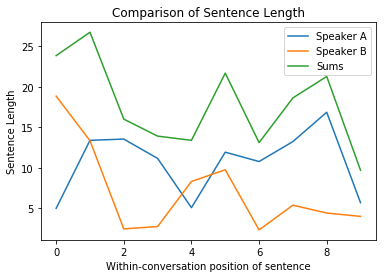

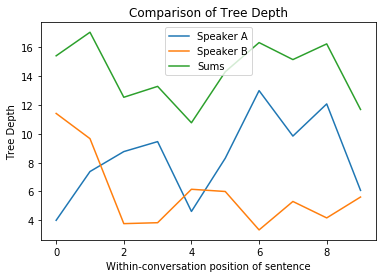

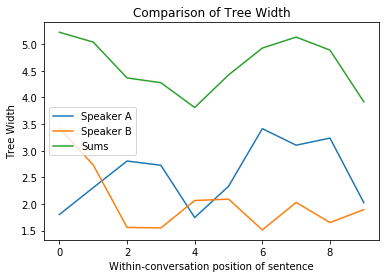

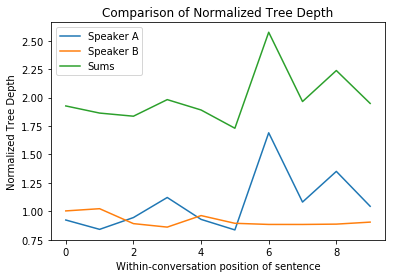

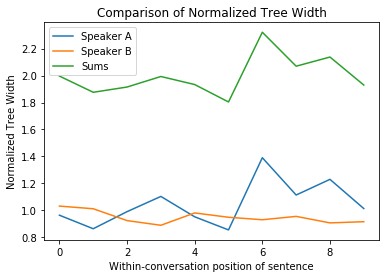

In [13]:
chunk_means = collect_speaker_data(wrappers = transcripts_list[0], num_bins = 10)
for measure in range(5):
    plot_speaker_data(chunk_means, measure)


## Topic segmentation with TextTiling

In [14]:
def get_transcript_texts():
    transcript_texts = []
    for transcript in corpus.iter_transcripts(display_progress=True):
        conversation_text = []
        last_turn_index = 0
        for utterance in transcript.utterances:
            current_turn_id = utterance.turn_index
            if current_turn_id != last_turn_index:
                conversation_text.append("\n\n")
            conversation_text.append(" ".join(utterance.pos_words()))
            last_turn_index = current_turn_id
        transcript_texts.append(conversation_text)

        break
        # TODO: Remove # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
        
    # print(" ".join(transcript_texts[0]))       
    return transcript_texts

In [15]:
def get_topic_start_indexes(tiles, transcript_data):
    topic_start_indexes = []
    w = 0
    for t, tile in enumerate(tiles): 
    #     print("Checking tile", t)
        while w <= len(transcript_data):
            # Get the first two utterances from the transcript data 
            wrapper = transcript_data[w].text + transcript_data[w+1].text
    #         print("Tile", tile.rsplit()[:len(wrapper)])
    #         print("Wrapper ", wrapper)
            if wrapper == tile.rsplit()[:len(wrapper)]:
    #             print("Topic start in turn {}".format(w))
                topic_start_indexes.append(w)
                w += 1
                break
            w += 1
    #     print("Tile {}: {}".format(i, tile))
    return topic_start_indexes

## Show the comparison of measurements over time

In [16]:
def collect_topic_data(transcript_texts, transcripts_list, num_bins = 10):
    for i, text in enumerate(transcript_texts):
        tiles = ttt.tokenize(" ".join(text))
        topic_start_indexes = get_topic_start_indexes(tiles, transcripts_list[i])
    #     print(topic_start_indexes)

        wrapper_list = transcripts_list[i]
        tile_counter = 1
        last_index = topic_start_indexes[0]
        for i in topic_start_indexes[1:]:
            print("Topic segment {}: Utterances {} through {}".format(tile_counter, last_index, i))
            wrappers = wrapper_list[last_index:i+1]
            
            # TODO: Almost all of the topic segments are too short to reliably return data! # # # 
            
            if len(wrappers) < num_bins:
                print("Topic only contained {} utterances. Skipped.".format(len(wrappers)))
                tile_counter += 1
                last_index = i
                continue
                
            chunk_means = collect_speaker_data(wrappers, num_bins)
            for measure in range(5):
                plot_speaker_data(chunk_means, measure)
                break
            tile_counter += 1
            last_index = i
            
        break
        # TODO: Remove # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

transcript 1

1
Topic segment 1: Utterances 0 through 3
Topic only contained 4 utterances. Skipped.
Topic segment 2: Utterances 3 through 13


/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


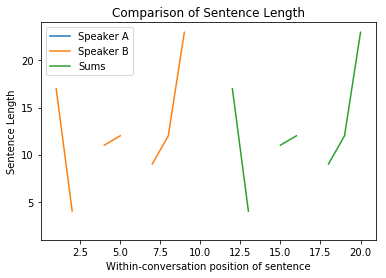

Topic segment 3: Utterances 13 through 21
Topic only contained 9 utterances. Skipped.
Topic segment 4: Utterances 21 through 28
Topic only contained 8 utterances. Skipped.
Topic segment 5: Utterances 28 through 42


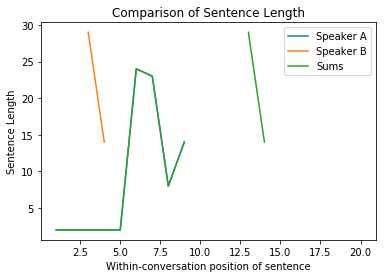

Topic segment 6: Utterances 42 through 52


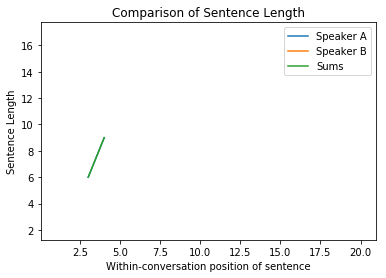

Topic segment 7: Utterances 52 through 61


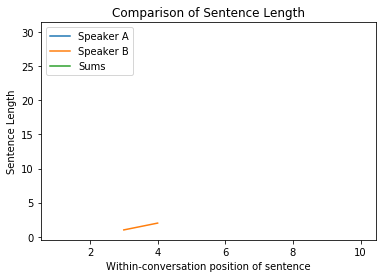

Topic segment 8: Utterances 61 through 77


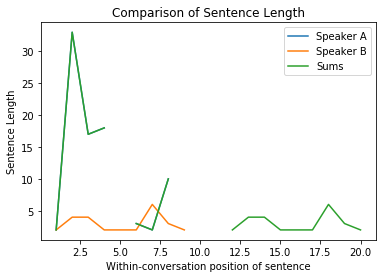

Topic segment 9: Utterances 77 through 86


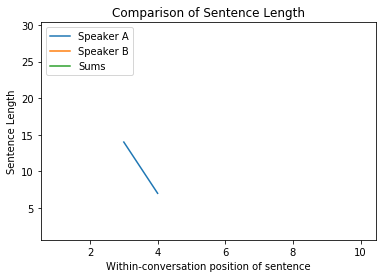

Topic segment 10: Utterances 86 through 106


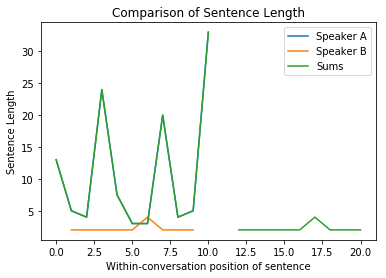

Topic segment 11: Utterances 106 through 118


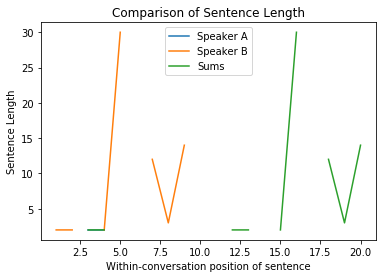

Topic segment 12: Utterances 118 through 128


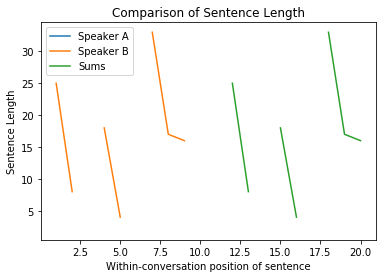

Topic segment 13: Utterances 128 through 151


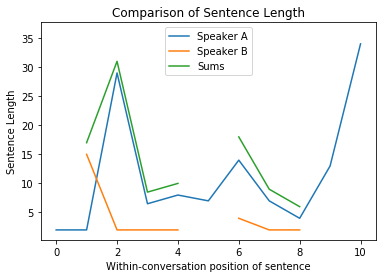

Topic segment 14: Utterances 151 through 167


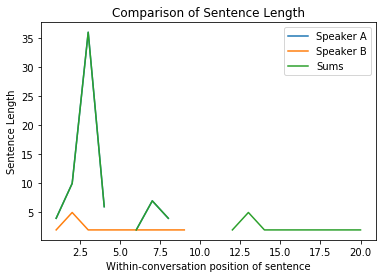

Topic segment 15: Utterances 167 through 179


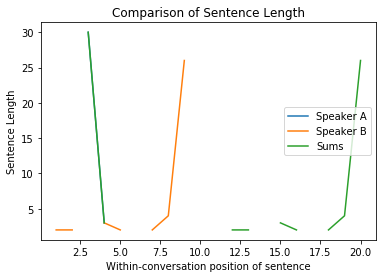

In [17]:
print(len(transcripts_list))
transcript_texts = get_transcript_texts()
collect_topic_data(transcript_texts, transcripts_list)